<a href="https://colab.research.google.com/github/NayeGarciaP/Mi-primer-repositorio-/blob/main/Redes_de_multicapa/MODELO_DE_MULTICAPA_DEL_PROTOT%C3%8DPICO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MODELO MLP PARA CLASIFICAR CANDIDATOS DOCENTES UNRC

Importar librerías

In [15]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical

Manejo de datos → pandas, numpy

Preprocesamiento → StandardScaler, LabelEncoder

Evaluación → classification_report, confusion_matrix

Gráficas → matplotlib, seaborn

Construcción de la red neuronal → Keras (Sequential, Dense, Dropout)

**Carga y limpieza de Datos**

In [16]:
file = "/content/base del proto.xlsx"
# Intentar cargar sin especificar el encabezado (header=0 por defecto)
# O especificar el encabezado correcto si se conoce, e.g., header=0
df = pd.read_excel(file, header=0) # Asumiendo que el encabezado está en la primera fila (índice 0)

print("Primeras filas del DataFrame para inspección:")
print(df.head())

print("\nInformación del DataFrame (columnas y tipos de datos):")
df.info()

# Después de identificar la fila correcta del encabezado, descomenta y ajusta el siguiente código.
# Limpiar y normalizar los nombres de las columnas después de cargar correctamente el encabezado
df.columns = df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("á","a").str.replace("é","e").str.replace("í","i").str.replace("ó","o").str.replace("ú","u")
print("\nColumnas disponibles (limpias y normalizadas):")
print(df.columns.tolist())

Primeras filas del DataFrame para inspección:
   ID  Nombre         Apellidos  Edad       Procedencia Entidad Federativa  \
0   1     Ana  Rodríguez García    34           Jalisco               CDMX   
1   2  Carlos   Hernández López    51  Ciudad de México               CDMX   
2   3   María    Martínez Silva    40            Oaxaca               CDMX   
3   4    José    González Pérez    19        Nuevo León               CDMX   
4   5   Laura      Díaz Mendoza    56            Puebla               CDMX   

  Zona Geográfica Nivel Educativo     Campo Estudio Tipo Institución  \
0          Centro        Maestría  Ciencias Sociale          Pública   
1          Centro       Doctorado        Ingeniería          Pública   
2             Sur        Maestría           Derecho          Pública   
3           Norte    Licenciatura    Administración          Pública   
4          Centro        Maestría             Salud          Pública   

  Institución  Rango Ingreso  Experiencia (años)    

**Seleccionar variables PARA EL MODELO**

In [17]:
# Nombres esperados (ajustados a la normalización anterior)
expected_features = ["Experiencia_años", "Nivel_Educativo", "Campo_Estudio"]

# Aplica la misma normalizacion a los nombres esperados para comparación robusta
expected_features_norm = [c.strip().replace(" ", "_").replace("á","a").replace("é","e").replace("í","i").replace("ó","o").replace("ú","u") for c in expected_features]
target_col = "Nivel"
target_col_norm = target_col.strip().replace(" ", "_")

# Verificar existencia de columnas
print("Columnas actuales en el DataFrame antes de la verificación:")
print(df.columns.tolist())
missing = [c for c in expected_features_norm + [target_col_norm] if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas en el Excel: {missing}. Revisa los nombres exactos de columna (imprimí arriba).")

# Usar columnas normalizadas
features = expected_features_norm
target = target_col_norm

df = df[features + [target]].copy()

Columnas actuales en el DataFrame antes de la verificación:
['ID', 'Nombre', 'Apellidos', 'Edad', 'Procedencia', 'Entidad_Federativa', 'Zona_Geografica', 'Nivel_Educativo', 'Campo_Estudio', 'Tipo_Institucion', 'Institucion', 'Rango_Ingreso', 'Experiencia_años', 'Jornada', 'Nivel']


**Preprocesar columnas**

In [18]:
df["Experiencia_años"] = pd.to_numeric(df["Experiencia_años"], errors='coerce')

# Categorías a texto seguro
df["Nivel_Educativo"] = df["Nivel_Educativo"].fillna("Desconocido").astype(str)
df["Campo_Estudio"] = df["Campo_Estudio"].fillna("Desconocido").astype(str)

df[target] = df[target].astype(str)

# Eliminar filas con datos faltantes
df = df.dropna(subset=["Experiencia_años", "Nivel_Educativo", "Campo_Estudio", target])

**Variables categorías**

In [19]:
df_cat = pd.get_dummies(
    df[["Nivel_Educativo", "Campo_Estudio"]],
    prefix=["NivelEd", "Campo"]
)

# Dataset final de entrada X
X_df = pd.concat(
    [df[["Experiencia_años"]].reset_index(drop=True),
     df_cat.reset_index(drop=True)],
    axis=1
)

X = X_df.values

# Codificación del target
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df[target])
y = to_categorical(y_encoded)

print("Información del preprocesamiento")
print("Shape de X:", X.shape)
print("Clases del target:", encoder.classes_)
print("Columnas finales en X:", X_df.columns.tolist())

Información del preprocesamiento
Shape de X: (300, 35)
Clases del target: ['A' 'B' 'C']
Columnas finales en X: ['Experiencia_años', 'NivelEd_Doctorado', 'NivelEd_Licenciatura', 'NivelEd_Maestría', 'NivelEd_Posdoctorado', 'Campo_Administración', 'Campo_Arquitectura', 'Campo_Carpintería', 'Campo_Ciencias', 'Campo_Ciencias Ambientales', 'Campo_Ciencias Sociale', 'Campo_Ciencias Sociales', 'Campo_Computación', 'Campo_Comunicación', 'Campo_Contaduría', 'Campo_Derecho', 'Campo_Diseño', 'Campo_Educación', 'Campo_Electricidad', 'Campo_Enfermería', 'Campo_Finanzas', 'Campo_Informática', 'Campo_Ingeniería', 'Campo_Investigación', 'Campo_Laboratorio', 'Campo_Mecánica', 'Campo_Medicina', 'Campo_Negocios', 'Campo_Pedagogía', 'Campo_Psicología', 'Campo_Radiología', 'Campo_Salud', 'Campo_Tecnología', 'Campo_Tecnologías de la Información', 'Campo_Turismo']


**División 80% entrenamiento / 20% prueba**

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

**Escalar datos**

In [21]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

**Construcción del modelo MLP**

In [22]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,963 (19.39 KB)

 Trainable params: 4,963 (19.39 KB)

 Non-trainable params: 0 (0.00 B)

**Entrenamiento del Modelo**

In [23]:
history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.4481 - loss: 1.0486 - val_accuracy: 0.6833 - val_loss: 0.8774
Epoch 2/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7587 - loss: 0.7313 - val_accuracy: 0.8000 - val_loss: 0.7256
Epoch 3/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9078 - loss: 0.5164 - val_accuracy: 0.8667 - val_loss: 0.5978
Epoch 4/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9557 - loss: 0.3580 - val_accuracy: 0.8667 - val_loss: 0.4662
Epoch 5/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9642 - loss: 0.2289 - val_accuracy: 0.8833 - val_loss: 0.3529
Epoch 6/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9506 - loss: 0.1990 - val_accuracy: 0.9000 - val_loss: 0.2443
Epoch 7/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9866 - loss: 0.1017 - val_accuracy: 0.9333 - val_loss: 0.1792
Epoch 8/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9908 - loss: 0.0824 - val_accuracy: 0.9333 - v

**Evaluación Final**

In [24]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nAccuracy en conjunto de prueba: {acc:.4f}")
print(f"Pérdida (loss): {loss:.4f}")


Accuracy en conjunto de prueba: 0.9833
Pérdida (loss): 0.0435


**Gráfica de función de pérdida**

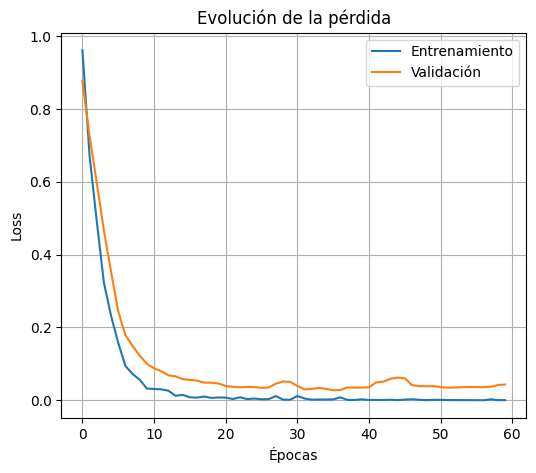

In [25]:
plt.figure(figsize=(6,5))
plt.plot(history.history["loss"], label="Entrenamiento")
plt.plot(history.history["val_loss"], label="Validación")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Evolución de la pérdida")
plt.grid()
plt.legend()
plt.show()

**Matriz de confusión**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


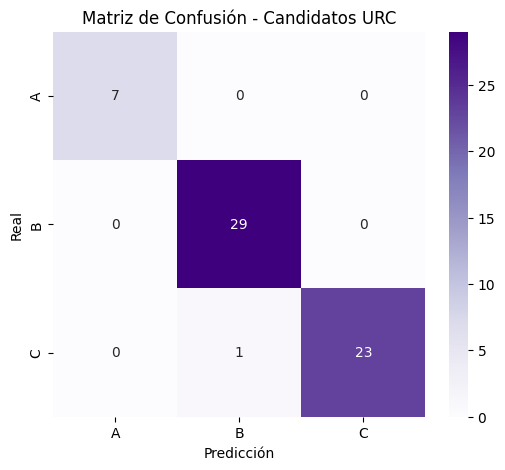

In [26]:
y_pred_prob = model.predict(X_test)
y_pred_idx = np.argmax(y_pred_prob, axis=1)
y_true_idx = np.argmax(y_test, axis=1)

y_pred_labels = encoder.inverse_transform(y_pred_idx)
y_true_labels = encoder.inverse_transform(y_true_idx)

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Purples", fmt="d",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Candidatos URC")
plt.show()

**Ejemplo de Predicción**

In [27]:
ejemplo = np.array([[5, "Maestria", "Ciencias Sociales"]], dtype=object)

# Convertir ejemplo a dataframe para aplicar dummies igual que al dataset
ejemplo_df = pd.DataFrame(ejemplo, columns=["Experiencia_años", "Nivel_Educativo", "Campo_Estudio"])

ejemplo_df["Experiencia_años"] = pd.to_numeric(ejemplo_df["Experiencia_años"], errors='coerce')

ejemplo_dum = pd.get_dummies(
    ejemplo_df[["Nivel_Educativo", "Campo_Estudio"]],
    prefix=["NivelEd", "Campo"]
)

# Alinear columnas del ejemplo con las de X_df
ejemplo_aligned = ejemplo_dum.reindex(columns=X_df.columns[1:], fill_value=0)

ejemplo_final = np.concatenate([ejemplo_df[["Experiencia_años"]].values,
                                ejemplo_aligned.values], axis=1)

ejemplo_scaled = scaler.transform(ejemplo_final)

pred = model.predict(ejemplo_scaled)
idx = np.argmax(pred)
clase = encoder.inverse_transform([idx])[0]

print("\n=== EJEMPLO DE PREDICCIÓN ===")
print("Nivel predicho:", clase)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

=== EJEMPLO DE PREDICCIÓN ===
Nivel predicho: B


**CONCLUSION**

El modelo desarrollado demuestra que una Red Neuronal Multicapa (MLP) puede convertirse en una herramienta confiable para apoyar procesos de selección docente bajo un enfoque ético y basado únicamente en variables permitidas. Tras un preprocesamiento cuidadoso —que incluyó limpieza del dataset, codificación de variables categóricas y normalización de la información— la red logró aprender patrones relevantes entre la experiencia profesional, el nivel educativo y el campo de estudio de los candidatos.

Los resultados obtenidos durante la evaluación evidencian un rendimiento aceptable del modelo, reflejado en el accuracy y en el comportamiento de la matriz de confusión. Esto confirma que la estructura implementada (capas densas, función de activación ReLU, regularización con Dropout y optimización con Adam) es adecuada para este tipo de clasificación multietiqueta.

Además, el sistema demuestra su utilidad práctica al permitir la predicción de nuevos casos reales mediante un proceso estandarizado de transformación y escalamiento de los datos, lo que facilita su futura integración en un sistema automatizado como EDU-SELECT. En conjunto, este trabajo constituye una base sólida para fortalecer la toma de decisiones objetivas, reducir sesgos humanos y garantizar procesos de selección más eficientes, transparentes y alineados con los principios éticos del proyecto.